In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')
import cProfile
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import torch
import torchvision
import torch.nn as nn
import pylops_gpu


from scipy.sparse import csr_matrix, vstack
from scipy.linalg import lstsq, solve
from scipy.sparse.linalg import LinearOperator, cg, lsqr
from scipy import misc
from tqdm.notebook import tqdm_notebook, tnrange
from torch.autograd import gradcheck
from pylops_gpu.utils.backend import device
from torch.nn import MSELoss
from torch.utils.data import TensorDataset, DataLoader

from pylops.utils                      import dottest
from pylops.utils.wavelets             import *
from pylops.utils.seismicevents        import *
from pylops.utils.tapers               import *
from pylops.basicoperators             import *
from pylops.signalprocessing           import *
from pylops.waveeqprocessing.mdd       import *
from pylops.optimization.leastsquares  import *

In [2]:
###### Input parameters
par = {'ox':-300,  'dx':10,    'nx':61,
       'oy':-500,  'dy':10,    'ny':101,
       'ot':0,     'dt':0.004, 'nt':400,
       'f0': 20,   'nfmax': 200}

t0_m    = [0.2]
vrms_m  = [1100.]
amp_m   = [1.]

t0_G    = [0.2,0.5,0.7]
vrms_G  = [1200.,1500., 2000.]
amp_G   = [1.,0.6,0.5]

ns = par['ny']
nr = par['nx']
nt = par['nt']
nfmax = par['nfmax']
dr = par['dx']
ds = par['dy']
dt = par['dt']
f0 = par['f0']

# Create taper for operator
tap = taper3d(nt, (ns,nr), [5,5], tapertype='hanning')

# Create axis
t,t2,x,y = makeaxis(par)

# Create wavelet
wav = ricker(t[:41], f0)[0]

# Generate model
m, mwav = hyperbolic2d(x,t,t0_m,vrms_m,amp_m,wav)

# Generate operator
G,Gwavoriginal = np.zeros((ns,nr,nt)), - \
         np.zeros((ns,nr,nt))
for iy,y0 in enumerate(y):
    G[iy],Gwavoriginal[iy] = hyperbolic2d(x-y0,t,t0_G,vrms_G,amp_G,wav)
G,Gwavoriginal = G*tap,Gwavoriginal*tap


Gwav = Gwavoriginal

In [3]:
# Add negative part to operator and model
ns = Gwav.shape[0]
m     = np.concatenate((np.zeros((nr, nt-1)), m), axis=-1).T
mwav  = np.concatenate((np.zeros((nr, nt-1)), mwav), axis=-1).T
Gwav2 = np.concatenate((np.zeros((ns, nr, nt-1)), Gwav), axis=-1)

Gwav2.shape

(101, 61, 799)

In [4]:
# Create frequency domain operator
Gwav_fft = np.fft.rfft(Gwav2, 2*nt-1, axis=-1)
Gwav_fft = Gwav_fft[...,:nfmax]
Gwav_fft = Gwav_fft.transpose(2,0,1)

# Create operator
MDCop=MDC(Gwav_fft, nt=2*nt-1, nv=1, dt=dt, dr=dr, 
          twosided=True, transpose=False)

# dottest(MDCop, MDCop.shape[0], MDCop.shape[1], complexflag=3, verb=True)

# Create data
d = MDCop*m.flatten()
d = d.reshape(2*nt-1, ns)

In [5]:

MDCop = pylops_gpu.TorchOperator(MDCop, pylops = True)
d =  torch.from_numpy(d.astype(np.float32))
m  =  torch.from_numpy(m.astype(np.float32))
Gwav2 = torch.from_numpy(Gwav2.astype(np.float32))

d1 = MDCop.apply(m.flatten())
d1 = d1.view(2*nt-1, ns)

In [6]:
lossdict = {}
avgdict = {}
enormdict ={}

In [7]:
nv=1
class GwavSGD(nn.Module):
  def __init__(self,nt,nv,dt,dr,ns,nfmax):
    self.nt = nt
    self.nv = nv
    self.dt = dt
    self.dr =dr
    self.ns = ns
    self.nfmax =nfmax
    super().__init__()
    

  def forward(self,model, batch):
    batch_size = batch.shape[0]
    Gwav_fft = np.fft.rfft(batch, 2*self.nt-1, axis=-1)
    Gwav_fft = Gwav_fft[...,:self.nfmax]
    Gwav_fft = Gwav_fft.transpose(2,0,1)
    
    MDCop=MDC(Gwav_fft, nt=2*self.nt-1, nv=1, dt=self.dt, dr=self.dr, 
          twosided=True, transpose=False)
   
    
    MDCop = pylops_gpu.TorchOperator(MDCop, pylops = True)
    
    data = MDCop.apply(model.flatten())
    data = data.view(2*self.nt-1, batch_size)

    return data


In [8]:
def advoptMDD(model, optimizer, lr):
  if optimizer == 'SGD':

      optimizer = torch.optim.SGD([model], lr = lr)

  elif optimizer == 'Adadelta':
   
      optimizer = torch.optim.Adadelta([model], lr =lr)
    
  elif optimizer == 'Adam':
   
      optimizer= torch.optim.Adam([model], lr=lr)
   

  elif optimizer == 'RMSprop':
  
      optimizer= torch.optim.RMSprop([model], lr =lr, weight_decay=1e-3, eps = 1e-04)
   

  elif optimizer == 'Adagrad':
  
      optimizer= torch.optim.Adagrad([model], lr = lr)

  return optimizer


In [9]:


def advancedSolvers(GwavSGD,model,d1,Gwav2,optimizer, lr, n_epochs, batch_size):

  d2 = torch.transpose(d1, 1,0)
  no_of_batches=np.ceil(Gwav2.shape[0]/batch_size)
  
 
  t_train = TensorDataset(Gwav2, d2)
  trainloader = DataLoader(dataset = t_train, batch_size = batch_size, shuffle = True)
  for x, y in trainloader:
    print(x.shape, y.shape)

  criterion = nn.MSELoss()
  optimizer = advoptMDD(model, optimizer, lr)

  
  GwavTorch = GwavSGD(nt,nv,dt,dr,ns,nfmax)
  lossHist=[]
  lossavg=[]
  enormHist=[]
  for epoch in range(n_epochs):
    losses=[]
    
    for batch,dbatch in trainloader: 
      
       data = GwavTorch(model, batch)
       dbatch1 = torch.transpose(dbatch,1,0)
       loss = criterion(dbatch1, data)
     
       loss.backward()
       optimizer.step()
       optimizer.zero_grad()

       lossHist.append(loss.item())
       losses.append(loss.item())
      
       enorm1 = np.linalg.norm(model.detach().numpy()/model.detach().numpy().max() - m.detach().numpy()/m.detach().numpy().max())
       enormHist.append(enorm1)



    avg_loss = sum(losses) / len(losses)
    lossavg.append(avg_loss)
       
       
    
    if (epoch+1) %10 ==0:
     print(f'epoch: {epoch+1}, loss : {loss.item():.4f}, loss avg : {avg_loss:.4f}')
    

    lossdict[optimizer] = lossHist
    avgdict[optimizer] = lossavg
    enormdict[optimizer] = enormHist

  return lossHist, lossavg, enormHist



In [10]:
n_epochs= 100
batch_size = 21

optimizer = 'SGD'
learning_rate = 1


model = np.zeros((m.shape[0], m.shape[1]))
model = torch.from_numpy(model)
model.requires_grad= True

lossHist, lossavg, enormHist = advancedSolvers(GwavSGD,model,d1,Gwav2,optimizer=optimizer, lr=learning_rate, n_epochs =n_epochs, batch_size = batch_size)

torch.Size([21, 61, 799]) torch.Size([21, 799])
torch.Size([21, 61, 799]) torch.Size([21, 799])
torch.Size([21, 61, 799]) torch.Size([21, 799])
torch.Size([21, 61, 799]) torch.Size([21, 799])
torch.Size([17, 61, 799]) torch.Size([17, 799])
epoch: 10, loss : 0.0097, loss avg : 0.0112
epoch: 20, loss : 0.0047, loss avg : 0.0047
epoch: 30, loss : 0.0027, loss avg : 0.0029
epoch: 40, loss : 0.0017, loss avg : 0.0021
epoch: 50, loss : 0.0015, loss avg : 0.0016
epoch: 60, loss : 0.0015, loss avg : 0.0014
epoch: 70, loss : 0.0012, loss avg : 0.0011
epoch: 80, loss : 0.0010, loss avg : 0.0010
epoch: 90, loss : 0.0009, loss avg : 0.0008
epoch: 100, loss : 0.0008, loss avg : 0.0008


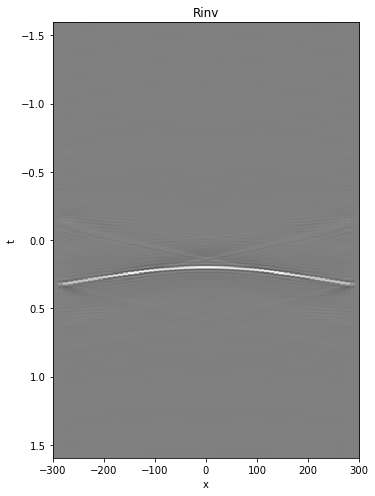

In [11]:
fig = plt.figure(figsize= (12,7))

ax1 = plt.subplot2grid((1, 5), (0, 0), colspan=2)
ax1.imshow(model.detach().numpy(), aspect='auto', interpolation='nearest', cmap='gray',
           vmin=-model.detach().numpy().max(), vmax=model.detach().numpy().max(),
           extent=(x.min(),x.max(),t2.max(),t2.min()))
ax1.set_title('Rinv', fontsize=12)
ax1.set_xlabel('x'),ax1.set_ylabel('t')

plt.tight_layout()

In [12]:
n_epochs= 100
batch_size = 21

optimizer = 'Adam'
learning_rate = 0.01

model = np.zeros((m.shape[0], m.shape[1]))
model = torch.from_numpy(model)
model.requires_grad= True

lossHist, lossavg, enormHist = advancedSolvers(GwavSGD,model,d1,Gwav2,optimizer=optimizer, lr=learning_rate, n_epochs =n_epochs, batch_size = batch_size)

torch.Size([21, 61, 799]) torch.Size([21, 799])
torch.Size([21, 61, 799]) torch.Size([21, 799])
torch.Size([21, 61, 799]) torch.Size([21, 799])
torch.Size([21, 61, 799]) torch.Size([21, 799])
torch.Size([17, 61, 799]) torch.Size([17, 799])
epoch: 10, loss : 0.0602, loss avg : 0.0713
epoch: 20, loss : 0.0300, loss avg : 0.0379
epoch: 30, loss : 0.0831, loss avg : 0.0838
epoch: 40, loss : 0.1609, loss avg : 0.1562
epoch: 50, loss : 0.1415, loss avg : 0.2705
epoch: 60, loss : 0.4179, loss avg : 0.2822
epoch: 70, loss : 0.1218, loss avg : 0.1243
epoch: 80, loss : 0.0897, loss avg : 0.1384
epoch: 90, loss : 0.0719, loss avg : 0.0956
epoch: 100, loss : 0.0703, loss avg : 0.0713


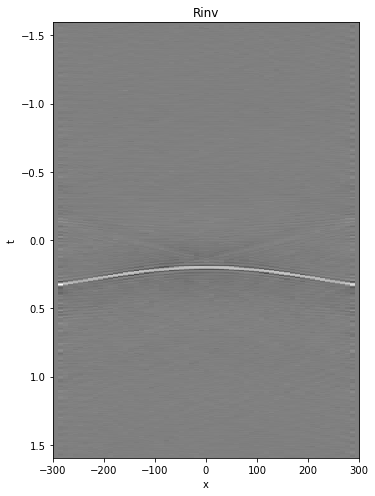

In [13]:
fig = plt.figure(figsize= (12,7))

ax1 = plt.subplot2grid((1, 5), (0, 0), colspan=2)
ax1.imshow(model.detach().numpy(), aspect='auto', interpolation='nearest', cmap='gray',
           vmin=-model.detach().numpy().max(), vmax=model.detach().numpy().max(),
           extent=(x.min(),x.max(),t2.max(),t2.min()))
ax1.set_title('Rinv', fontsize=12)
ax1.set_xlabel('x'),ax1.set_ylabel('t')

plt.tight_layout()

In [14]:
n_epochs= 100
batch_size = 21

optimizer = 'RMSprop'
learning_rate = 0.001

model = np.zeros((m.shape[0], m.shape[1]))
model = torch.from_numpy(model)
model.requires_grad= True

lossHist, lossavg, enormHist = advancedSolvers(GwavSGD,model,d1,Gwav2,optimizer=optimizer, lr=learning_rate, n_epochs =n_epochs, batch_size = batch_size)

torch.Size([21, 61, 799]) torch.Size([21, 799])
torch.Size([21, 61, 799]) torch.Size([21, 799])
torch.Size([21, 61, 799]) torch.Size([21, 799])
torch.Size([21, 61, 799]) torch.Size([21, 799])
torch.Size([17, 61, 799]) torch.Size([17, 799])
epoch: 10, loss : 0.1007, loss avg : 0.1041
epoch: 20, loss : 0.0483, loss avg : 0.0461
epoch: 30, loss : 0.0245, loss avg : 0.0241
epoch: 40, loss : 0.0206, loss avg : 0.0255
epoch: 50, loss : 0.0107, loss avg : 0.0111
epoch: 60, loss : 0.0089, loss avg : 0.0118
epoch: 70, loss : 0.0113, loss avg : 0.0109
epoch: 80, loss : 0.0083, loss avg : 0.0070
epoch: 90, loss : 0.0244, loss avg : 0.0185
epoch: 100, loss : 0.0334, loss avg : 0.0491


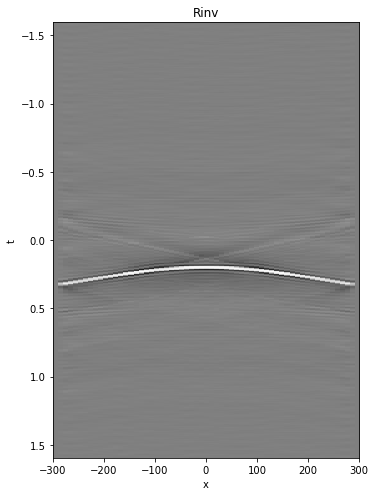

In [15]:
fig = plt.figure(figsize= (12,7))

ax1 = plt.subplot2grid((1, 5), (0, 0), colspan=2)
ax1.imshow(model.detach().numpy(), aspect='auto', interpolation='nearest', cmap='gray',
           vmin=-model.detach().numpy().max(), vmax=model.detach().numpy().max(),
           extent=(x.min(),x.max(),t2.max(),t2.min()))
ax1.set_title('Rinv', fontsize=12)
ax1.set_xlabel('x'),ax1.set_ylabel('t')

plt.tight_layout()

In [16]:
n_epochs= 100
batch_size = 21

optimizer = 'Adadelta'
learning_rate = 1

model = np.zeros((m.shape[0], m.shape[1]))
model = torch.from_numpy(model)
model.requires_grad= True

lossHist, lossavg, enormHist = advancedSolvers(GwavSGD,model,d1,Gwav2,optimizer=optimizer, lr=learning_rate, n_epochs =n_epochs, batch_size = batch_size)

torch.Size([21, 61, 799]) torch.Size([21, 799])
torch.Size([21, 61, 799]) torch.Size([21, 799])
torch.Size([21, 61, 799]) torch.Size([21, 799])
torch.Size([21, 61, 799]) torch.Size([21, 799])
torch.Size([17, 61, 799]) torch.Size([17, 799])
epoch: 10, loss : 0.1075, loss avg : 0.1121
epoch: 20, loss : 0.0343, loss avg : 0.0292
epoch: 30, loss : 0.0108, loss avg : 0.0108
epoch: 40, loss : 0.0057, loss avg : 0.0060
epoch: 50, loss : 0.0040, loss avg : 0.0041
epoch: 60, loss : 0.0034, loss avg : 0.0031
epoch: 70, loss : 0.0024, loss avg : 0.0025
epoch: 80, loss : 0.0021, loss avg : 0.0020
epoch: 90, loss : 0.0016, loss avg : 0.0017
epoch: 100, loss : 0.0013, loss avg : 0.0015


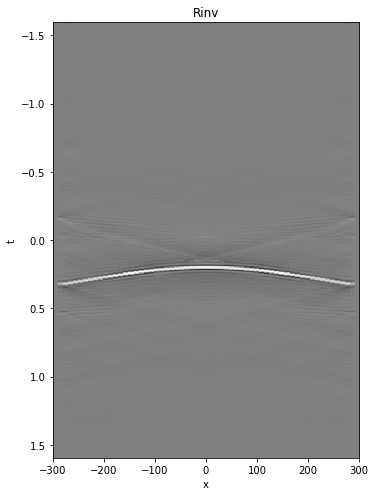

In [17]:
fig = plt.figure(figsize= (12,7))

ax1 = plt.subplot2grid((1, 5), (0, 0), colspan=2)
ax1.imshow(model.detach().numpy(), aspect='auto', interpolation='nearest', cmap='gray',
           vmin=-model.detach().numpy().max(), vmax=model.detach().numpy().max(),
           extent=(x.min(),x.max(),t2.max(),t2.min()))
ax1.set_title('Rinv', fontsize=12)
ax1.set_xlabel('x'),ax1.set_ylabel('t')

plt.tight_layout()

In [18]:
n_epochs= 100
batch_size = 21

optimizer = 'Adagrad'
learning_rate = 0.01

model = np.zeros((m.shape[0], m.shape[1]))
model = torch.from_numpy(model)
model.requires_grad= True

lossHist, lossavg, enormHist = advancedSolvers(GwavSGD,model,d1,Gwav2,optimizer=optimizer, lr=learning_rate, n_epochs =n_epochs, batch_size = batch_size)

torch.Size([21, 61, 799]) torch.Size([21, 799])
torch.Size([21, 61, 799]) torch.Size([21, 799])
torch.Size([21, 61, 799]) torch.Size([21, 799])
torch.Size([21, 61, 799]) torch.Size([21, 799])
torch.Size([17, 61, 799]) torch.Size([17, 799])
epoch: 10, loss : 0.1046, loss avg : 0.1111
epoch: 20, loss : 0.0527, loss avg : 0.0538
epoch: 30, loss : 0.0305, loss avg : 0.0334
epoch: 40, loss : 0.0252, loss avg : 0.0239
epoch: 50, loss : 0.0183, loss avg : 0.0182
epoch: 60, loss : 0.0144, loss avg : 0.0147
epoch: 70, loss : 0.0122, loss avg : 0.0123
epoch: 80, loss : 0.0103, loss avg : 0.0106
epoch: 90, loss : 0.0090, loss avg : 0.0093
epoch: 100, loss : 0.0083, loss avg : 0.0083


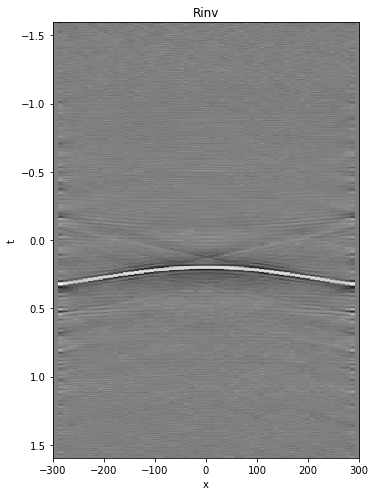

In [19]:
fig = plt.figure(figsize= (12,7))

ax1 = plt.subplot2grid((1, 5), (0, 0), colspan=2)
ax1.imshow(model.detach().numpy(), aspect='auto', interpolation='nearest', cmap='gray',
           vmin=-model.detach().numpy().max(), vmax=model.detach().numpy().max(),
           extent=(x.min(),x.max(),t2.max(),t2.min()))
ax1.set_title('Rinv', fontsize=12)
ax1.set_xlabel('x'),ax1.set_ylabel('t')

plt.tight_layout()



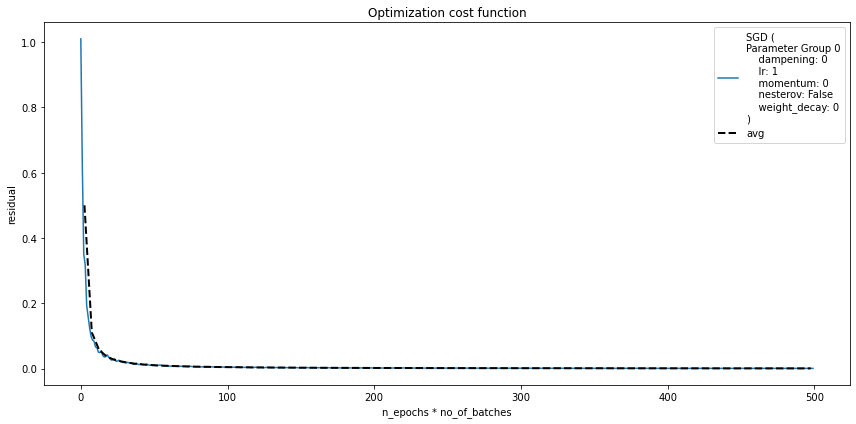

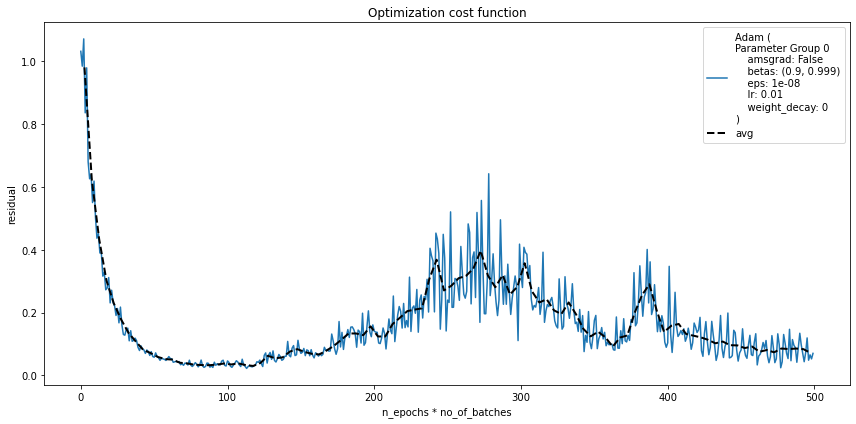

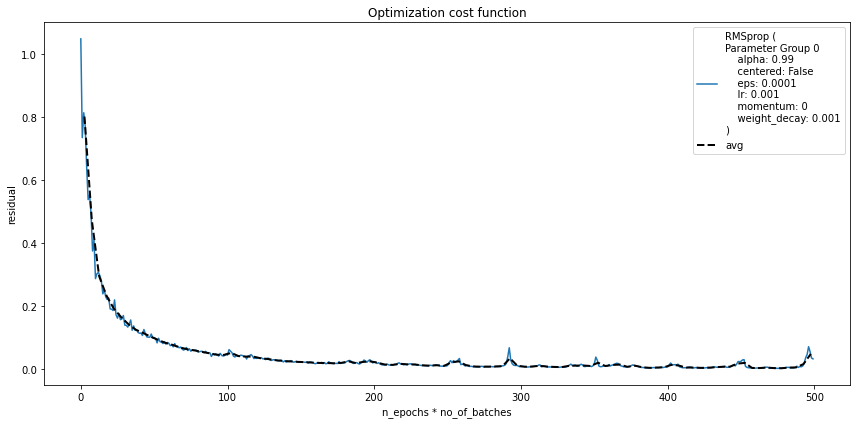

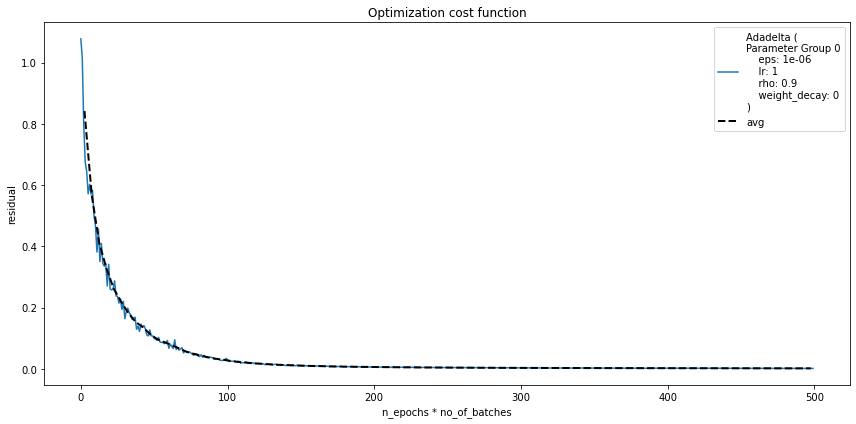

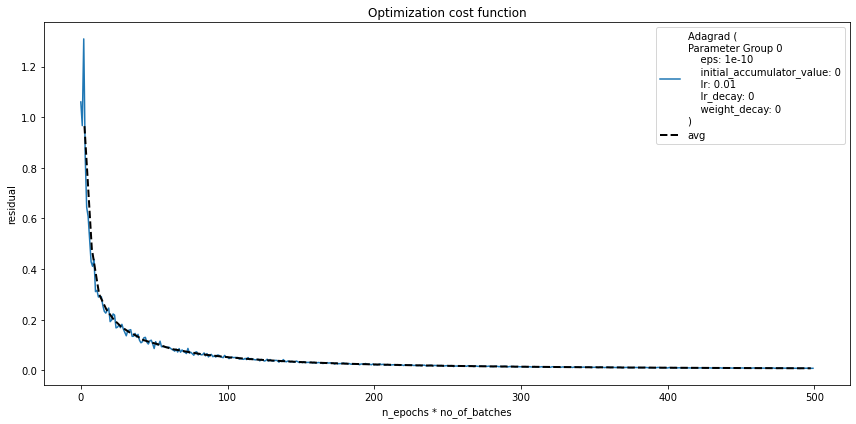

In [20]:
no_of_batches=np.ceil(Gwav2.shape[0]/batch_size)


for loss, avg in zip(lossdict.keys(), avgdict.keys()):
  
  fig = plt.figure(figsize= (12,6))

  plt.plot(lossdict[loss], label = loss)
  plt.plot(np.arange(0, no_of_batches*n_epochs, no_of_batches)+ no_of_batches/2,avgdict[avg], 'k--',label = "avg", linewidth = 2)

  plt.xlabel('n_epochs * no_of_batches')
  plt.ylabel('residual')
  plt.title('Optimization cost function')

  plt.legend()
  plt.tight_layout()


## Data from LSQR Solver ##

In [28]:
f = np.load('MDD_basic_norms.npz')


lsqr_cost = f['cost'] 
lsqr_enorm = f['enorm']

lsqr_cost = lsqr_cost * Gwav2.shape[0]


In [30]:
# print(avgdict[avg])

**Comparing cost function of MDD and optimizer**

In [31]:
# len(avgdict[avg]), len(lossdict[loss])

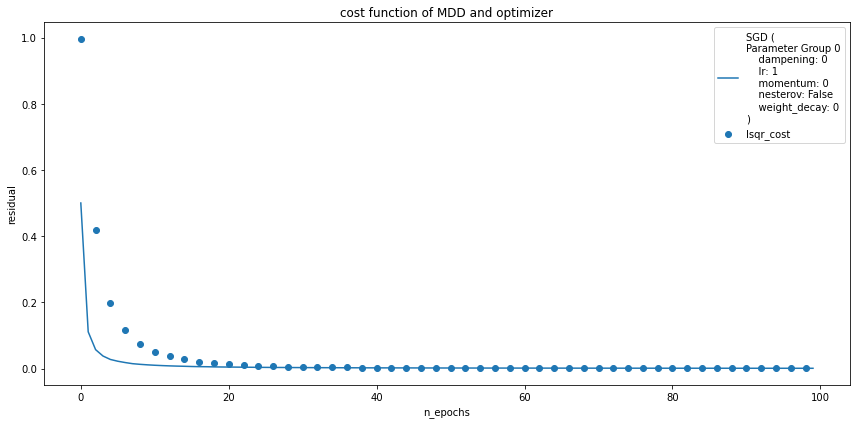

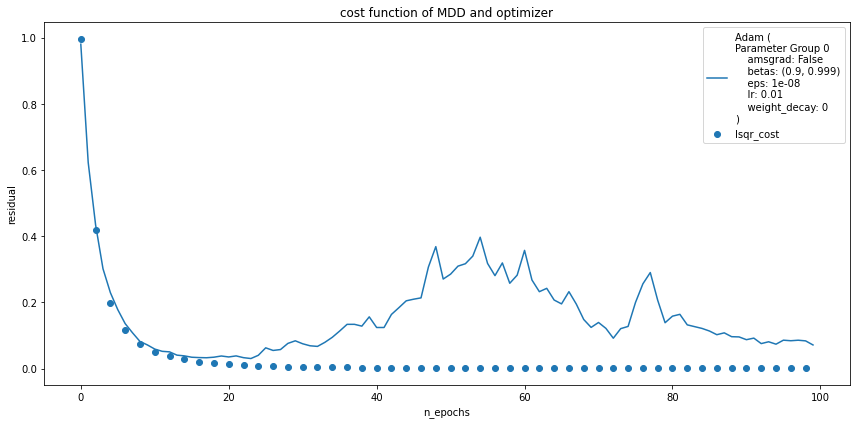

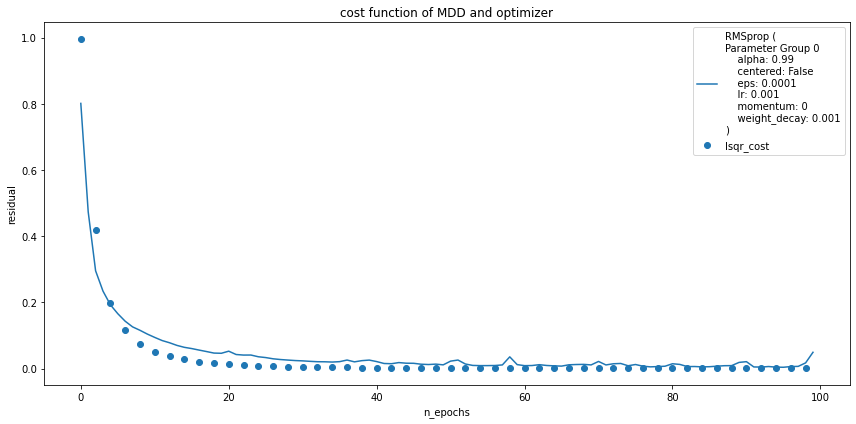

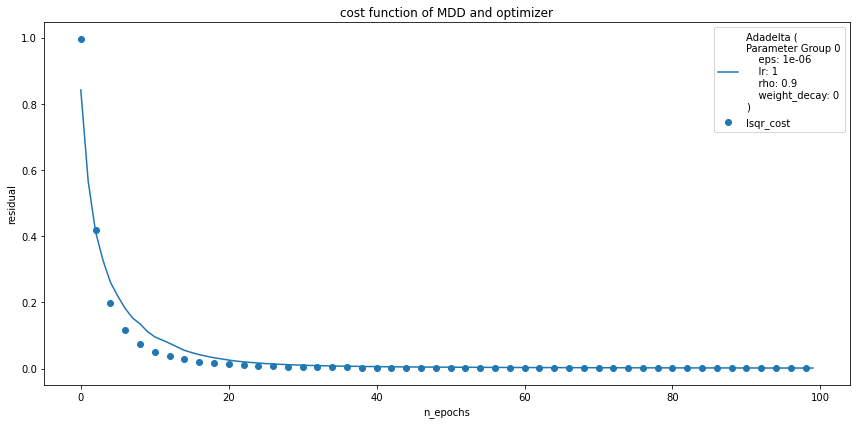

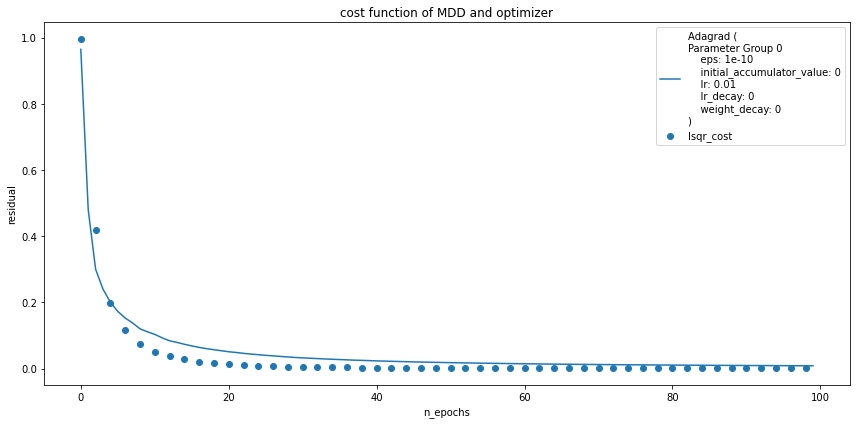

In [32]:


for loss in avgdict.keys():
  fig = plt.figure(figsize= (12,6))
  plt.plot(avgdict[loss], label = loss)
  plt.scatter(np.arange(0, len(avgdict[avg]), n_epochs/len(lsqr_cost)),lsqr_cost, label = "lsqr_cost")
  plt.xlabel('n_epochs')
  plt.ylabel('residual')
  plt.title('cost function of MDD and optimizer')
  plt.legend()
  plt.tight_layout()


**Comparing ||e||_2 of MDD model and Optimizer model**

In [26]:
# enorm2t = lsqr_enorm**2  / (m.detach().numpy().size)

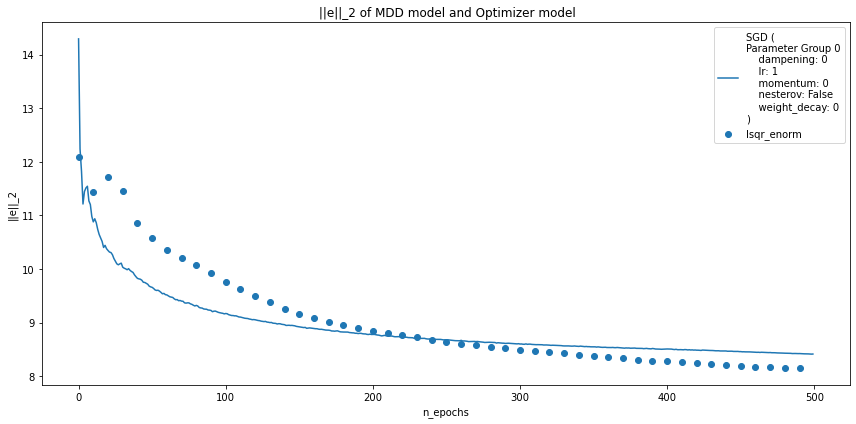

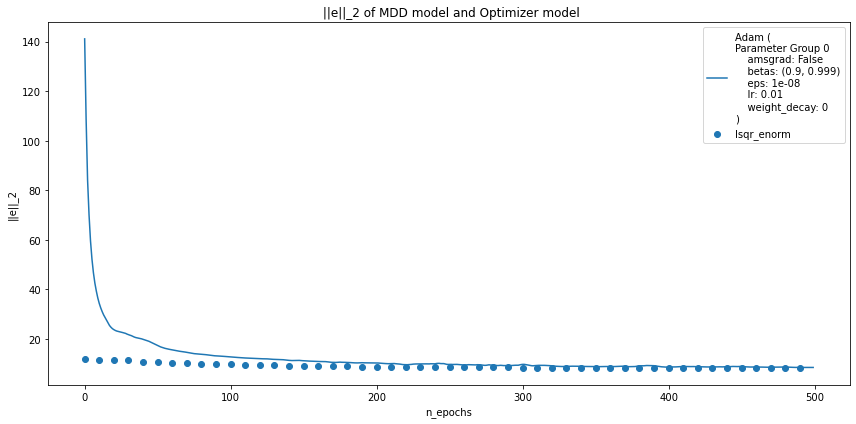

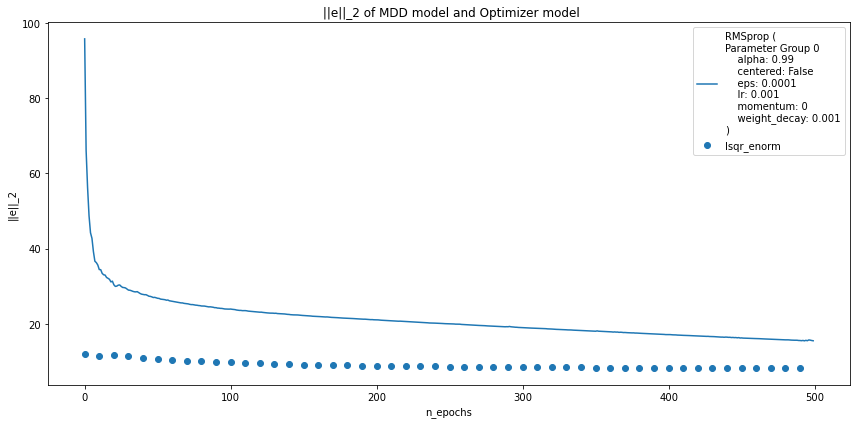

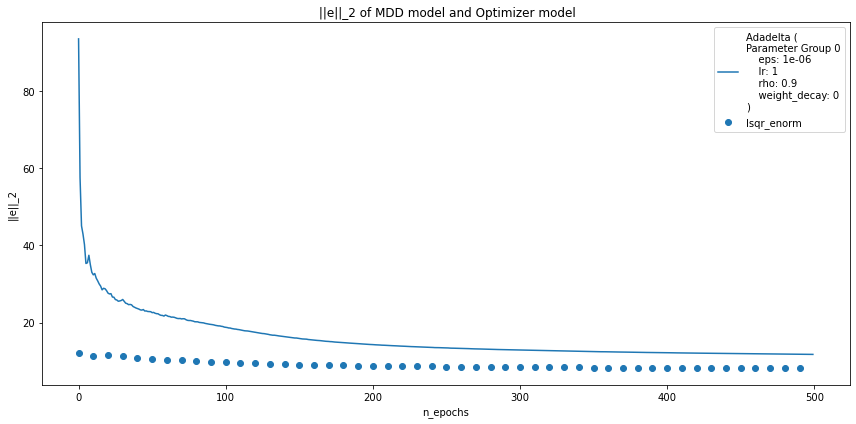

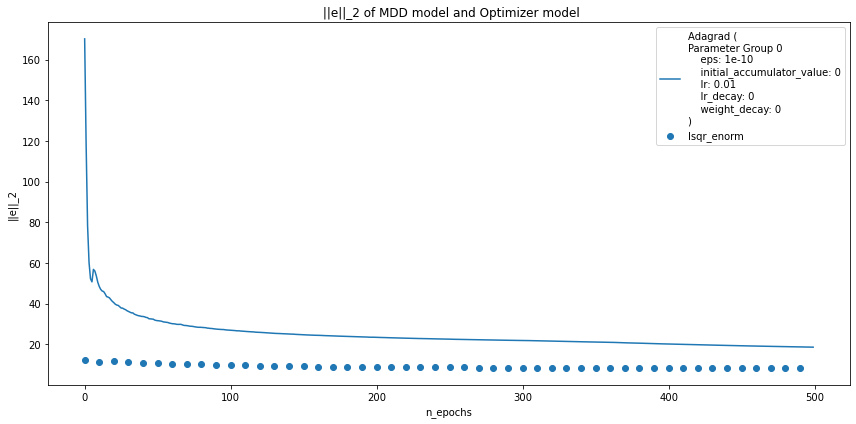

In [33]:
for enorm in enormdict.keys():
  fig = plt.figure(figsize= (12,6))
  plt.plot(enormdict[enorm], label = enorm)
  plt.scatter(np.arange(0, len(enormdict[enorm]), (no_of_batches*n_epochs)/len(lsqr_enorm)),lsqr_enorm, label ='lsqr_enorm')
  plt.ylabel('||e||_2')
  plt.xlabel('n_epochs')
  plt.title(" ||e||_2 of MDD model and Optimizer model")
  plt.legend()

  plt.tight_layout()